# Partial correlation between HFB responses, spectral envelope and pitch

In [1]:
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from scipy.stats import ttest_rel
from utils import load_fragment_times, zscore, run_partial_cor

%matplotlib inline

In [2]:
hdir = '../data/'
speech = load_fragment_times(hdir, 'speech')
nonspeech = load_fragment_times(hdir,'nonspeech')
aud = np.load('../data/audio_envelope_100Hz.npy')
pitch = np.loadtxt('../data/M3_audio_mono_down_pitch_short_edited')
onoff = np.load('../data/speech_on_off_100Hz.npy')

In [3]:
subj = 's1'
x    = np.load('../data/' + subj + '_HD_100Hz_hfb.npy')
pm = np.load('../results/ttest_ecog_speech_nonspeech_'+subj+'_pmask.npz')['pmask_bonf'] # pmask from the first ttest
grid = np.load('../data/' + subj + '_HD_grid.npy')
n = x.shape[-1]

In [4]:
# shift to max correlation lag per fragment
D = np.load('../results/xcor_'+subj+'_audio_envelope_100Hz_hfb_spearman.npz')
start = 400
r_spe = D['r_spe'][:,:,start:460]
rm = np.argmax(r_spe, 2)

maxr = np.zeros(rm.shape)
for i, f in enumerate(rm):
    for ir, r in enumerate(f):
        maxr[i, ir] = r_spe[i, ir][rm[i, ir]]

offset = 400 - start
rm = rm - offset

In [5]:
# select fragments and concatenate over time
x_spe, o_spe = [], []
for ifrag, spe_frag in enumerate(speech):
    x_spe.append([])
    o_spe.append(onoff[range(spe_frag[0], spe_frag[1])])
    for i in range(n):
        x_spe[-1].append(x[range(spe_frag[0]+rm[ifrag, i], spe_frag[1]+rm[ifrag, i]), i])
x_spe = np.array(x_spe)
o_spe = np.array(o_spe)

x_spe_c = x_spe.swapaxes(1, 2).reshape((-1, n))
o_spe_c = o_spe.reshape(-1, )

In [6]:
# find ols and get residuals
x_spe_cz = zscore(x_spe_c)
o_basis = np.vstack([np.ones(o_spe_c.shape[0]), o_spe_c]).T

x_betas, x_sumres, _, _ = linalg.lstsq(o_basis, x_spe_cz)

x_fit = o_basis.dot(x_betas)
x_rsd = x_spe_cz - x_fit
x_rsd_f = x_rsd.reshape((speech.shape[0], -1, n))

In [7]:
# compute partial correlation
x_aud_par = np.zeros((speech.shape[0], n))
x_pitch_par = np.zeros_like(x_aud_par)
aud_pitch_par = np.zeros_like(x_aud_par)
for i in range(speech.shape[0]):
    for e in range(n):
        temp = run_partial_cor(x_rsd_f[i, :, e], aud[speech[i, 0]:speech[i, 1]], pitch[speech[i, 0]:speech[i, 1]], 
                                                                                                       type='spearman')
        x_aud_par[i, e] = temp[0]
        x_pitch_par[i, e] = temp[1]
        aud_pitch_par[i, e] = temp[2]

In [8]:
# fisher transform
par_x_aud_f = np.arctanh(x_aud_par)
par_x_pitch_f = np.arctanh(x_pitch_par)

In [9]:
# t-test on parcor to spectral enveope and pitch
ts, ps = [], []
for i, j in zip(par_x_aud_f.T, par_x_pitch_f.T):
    t, p = ttest_rel(i, j)
    ts.append(t)
    ps.append(p)
ts, ps = np.array(ts), np.array(ps)

In [10]:
# significance
ts_masked = ts.copy()
pm = pm[3:] # take out STG electrodes of s1 out of the analysis

ts_masked[np.setdiff1d(range(n), pm)] = 0
thresh_05 = 5e-2/pm.shape[0]
thresh_01 = 1e-2/pm.shape[0]
thresh_001 = 1e-3/pm.shape[0]
ts_masked[ps >= thresh_01] = 0

In [11]:
print(np.mean(np.mean(x_aud_par[:, pm][:, ps[pm]<thresh_001], 0)))
print(np.std(np.mean(x_aud_par[:, pm][:, ps[pm]<thresh_001], 0)))

print(np.mean(np.mean(x_pitch_par[:, pm][:, ps[pm]<thresh_001], 0)))
print(np.std(np.mean(x_pitch_par[:, pm][:, ps[pm]<thresh_001], 0)))

0.14006033769562234
0.008884203061192024
-0.0059061616577558845
0.015221616208903666


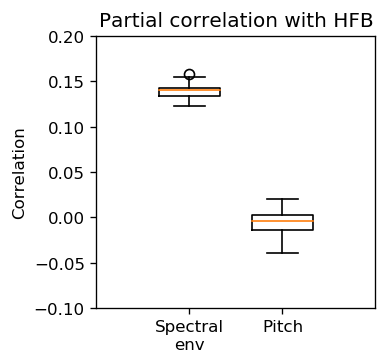

In [12]:
# boxplot for s1
plt.figure(figsize=(3, 3), dpi=120)
plt.boxplot([np.mean(x_aud_par, 0)[pm], np.mean(x_pitch_par, 0)[pm]], positions = [1, 1.5], widths=.33)
plt.ylim(-.1, .2)
plt.xticks([1, 1.5], ['Spectral\nenv', 'Pitch'])
plt.title('Partial correlation with HFB')
plt.ylabel('Correlation')
plt.show()

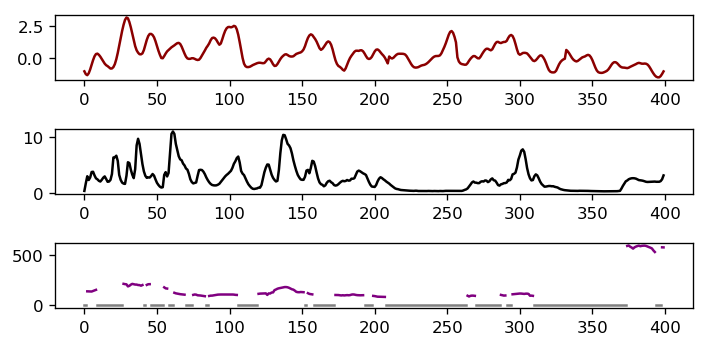

In [13]:
# time course plots
f = 64
e = 68

plt.figure(figsize=(6, 3), dpi=120)
plt.subplot(311)
plt.plot(x_rsd_f[f, :, e], 'darkred')

plt.subplot(312)
plt.plot(aud[speech[f, 0]:speech[f, 1]], 'k')

plt.subplot(313)
temp = pitch[speech[f, 0]:speech[f, 1]].copy()
temp[temp ==0] = np.nan
plt.plot(temp, 'purple')
temp = pitch[speech[f, 0]:speech[f, 1]].copy()
temp[temp > 0] = np.nan
plt.plot(temp, 'grey')

plt.tight_layout()
plt.show()
